In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import brute

In [11]:
class MRVectorBacktester(object): 
    ''' Class for the vectorized backtesting of mean reversion-based trading strategies.
    
    Attributes
    ==========
    symbol: str
        RIC symbol with which to work
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    amount: int, float amount to be invested at the beginning
    tc: float
        proportional transaction costs (e.g., 0.5% = 0.005) per trade
    Methods
    =======
    get_data:
        retrieves and prepares the base data set
    run_strategy:
        runs the backtest for the mean reversion-based strategy
    plot_results:
        plots the performance of the strategy compared to the symbol
    '''

    def __init__(self, start, end, amount, tc): 
        self.start = start
        self.end = end
        self.amount = amount
        self.tc = tc
        self.results = None
        self.get_data()
    
    def get_data(self):
        ''' 
        Retrieves and prepares the data.
        '''
        file_path = '/Users/benny/Downloads/USD_JPY Historical Data.csv'
        raw = pd.read_csv(file_path)
        raw['Date'] = pd.to_datetime(raw['Date'])
        raw.set_index('Date',inplace=True)
        raw.sort_index(ascending=True,inplace=True)
        raw.drop(['Open','High','Low','Vol.','Change %'], axis=1, inplace=True)
        raw['return'] = np.log(raw['Price'] / raw['Price'].shift(1))
        self.data = raw
        
    def run_strategy(self, SMA, threshold):
        ''' 
        Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data['sma'] = data['Price'].rolling(SMA).mean() 
        data['distance'] = data['Price'] - data['sma'] 
        data.dropna(inplace=True)
        
        # sell signals
        data['position'] = np.where(data['distance'] > threshold,-1, np.nan)
        
        # buy signals
        data['position'] = np.where(data['distance'] < -threshold,1, data['position'])
        
        # crossing of current price and SMA (zero distance)
        data['position'] = np.where(data['distance'] *data['distance'].shift(1) < 0,0, data['position'])
        data['position'] = data['position'].ffill().fillna(0)
        data['strategy'] = data['position'].shift(1) * data['return']
        
        # determine when a trade takes place
        trades = data['position'].diff().fillna(0) != 0
        
        # subtract transaction costs from return when trade takes place
        data['strategy'][trades] -= self.tc
        data['creturns'] = self.amount * data['return'].cumsum().apply(np.exp)
        data['cstrategy'] = self.amount * data['strategy'].cumsum().apply(np.exp)
        self.results = data
        
        # absolute performance of the strategy
        aperf = self.results['cstrategy'].iloc[-1]
        
        # out-/underperformance of strategy
        operf = aperf - self.results['creturns'].iloc[-1] 
        
        return round(aperf, 2), round(operf, 2)
    
    def plot_results(self):
        ''' 
        Plots the cumulative performance of the trading strategy compared to the symbol.
        '''
        if self.results is None:
            print('No results to plot yet. Run a strategy.') 
        title = 'TC = %.4f' % (self.tc) 
        self.results[['creturns', 'cstrategy']].plot(title=title,figsize=(10, 6))

In [16]:
mrbt = MRVectorBacktester( '2010-1-1', '2024-12-31',10000, 0.0)

In [17]:
print(mrbt.run_strategy(SMA=25, threshold=1))

(7863.89, -9550.52)


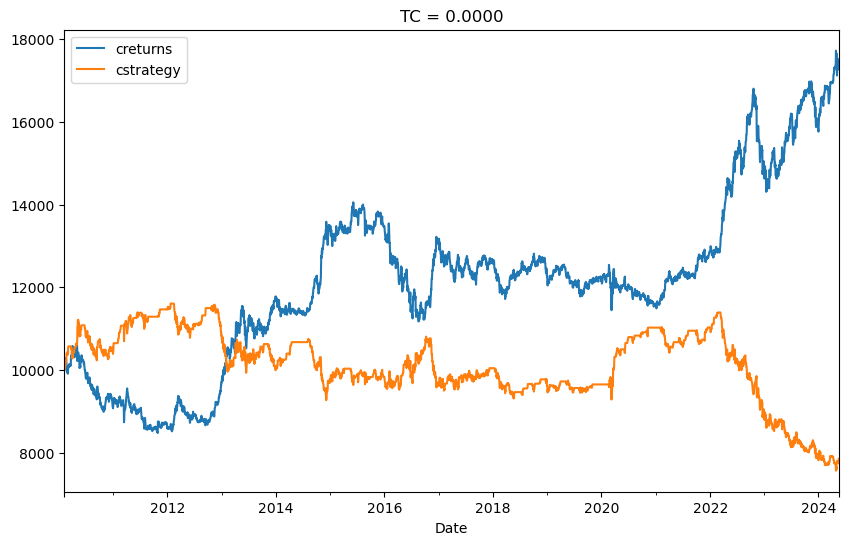

In [18]:
mrbt.plot_results()